# Prédiction de l'Attrition des Employés

## Objectif du Notebook

Ce notebook a pour but de construire un modèle de Machine Learning capable de **prédire l'attrition des employés** (départ de l'entreprise) et d'**analyser les facteurs** qui influencent cette décision.

### Plan du Notebook

1. **Extraction des données** - Chargement des CSV et feature engineering
2. **Analyse exploratoire** - Visualisations et corrélations
3. **Nettoyage des données** - Suppression colonnes problématiques et imputation
4. **Pipeline ML** - Préparation, entraînement et tuning des modèles
5. **Analyse du modèle** - Interprétation et feature importance

---
## Imports et Configuration

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# SMOTE for class imbalance
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score, fbeta_score
)

# Model persistence
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



---
# 1️ Extraction des Données

Nous avons 5 fichiers CSV à charger et fusionner :
- `general_data.csv` : Informations générales sur les employés
- `employee_survey_data.csv` : Données de satisfaction des employés
- `manager_survey_data.csv` : Évaluations des managers
- `in_time.csv` : Heures d'arrivée au travail
- `out_time.csv` : Heures de départ du travail

### 1.1 Chargement des fichiers CSV principaux

In [2]:
# Chargement des données principales
general_data = pd.read_csv('data/general_data.csv')
employee_survey = pd.read_csv('data/employee_survey_data.csv')
manager_survey = pd.read_csv('data/manager_survey_data.csv')

print("=" * 60)
print("GENERAL DATA")
print("=" * 60)
print(f"Shape: {general_data.shape}")
print(f"\nColonnes: {list(general_data.columns)}")
display(general_data.head(3))

print("\n" + "=" * 60)
print("EMPLOYEE SURVEY DATA")
print("=" * 60)
print(f"Shape: {employee_survey.shape}")
display(employee_survey.head(3))

print("\n" + "=" * 60)
print("MANAGER SURVEY DATA")
print("=" * 60)
print(f"Shape: {manager_survey.shape}")
display(manager_survey.head(3))

GENERAL DATA
Shape: (4410, 20)

Colonnes: ['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,131160,1.0,11,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,41890,0.0,23,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,193280,1.0,15,3,5.0,2,5,0,3



EMPLOYEE SURVEY DATA
Shape: (4410, 4)


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0



MANAGER SURVEY DATA
Shape: (4410, 3)


,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3


### 1.2 Chargement et traitement des données de pointage (in_time / out_time)

Les fichiers `in_time.csv` et `out_time.csv` contiennent les heures d'arrivée et de départ des employés pour chaque jour de l'année 2015. Nous allons créer des features agrégées :

- **Arrive_mean** : Moyenne des heures d'arrivée
- **Departure_mean** : Moyenne des heures de départ  
- **Worktime_mean** : Moyenne des heures travaillées par jour

In [3]:
# Chargement des données de pointage
in_time = pd.read_csv('data/in_time.csv')
out_time = pd.read_csv('data/out_time.csv')

print(f"in_time shape: {in_time.shape}")
print(f"out_time shape: {out_time.shape}")
print(f"\nNombre de jours enregistrés: {len(in_time.columns) - 1}")

in_time shape: (4410, 262)
out_time shape: (4410, 262)

Nombre de jours enregistrés: 261


In [4]:
def extract_time_features(in_time_df, out_time_df):
    """
    Extrait les features temporelles des données de pointage.
    
    Returns:
        DataFrame avec EmployeeID, Arrive_mean, Departure_mean, Worktime_mean
    """
    # Colonnes de dates (toutes sauf EmployeeID)
    date_cols = [col for col in in_time_df.columns if col != 'EmployeeID']
    
    results = []
    
    for _, row_in in in_time_df.iterrows():
        emp_id = row_in['EmployeeID']
        row_out = out_time_df[out_time_df['EmployeeID'] == emp_id].iloc[0]
        
        arrive_times = []  # En heures décimales
        depart_times = []  # En heures décimales
        work_durations = []  # En heures
        
        for date_col in date_cols:
            in_val = row_in[date_col]
            out_val = row_out[date_col]
            
            # Skip si NA (jour non travaillé)
            if pd.isna(in_val) or pd.isna(out_val) or in_val == 'NA' or out_val == 'NA':
                continue
            
            try:
                # Parse datetime
                in_dt = pd.to_datetime(in_val, format='%d/%m/%Y %H:%M')
                out_dt = pd.to_datetime(out_val, format='%d/%m/%Y %H:%M')
                
                # Heure d'arrivée en décimal (ex: 9h30 = 9.5)
                arrive_decimal = in_dt.hour + in_dt.minute / 60
                depart_decimal = out_dt.hour + out_dt.minute / 60
                
                # Durée de travail en heures
                work_hours = (out_dt - in_dt).total_seconds() / 3600
                
                # Validation: durée raisonnable (entre 1h et 16h)
                if 1 <= work_hours <= 16:
                    arrive_times.append(arrive_decimal)
                    depart_times.append(depart_decimal)
                    work_durations.append(work_hours)
                    
            except Exception:
                continue
        
        # Calcul des moyennes
        results.append({
            'EmployeeID': emp_id,
            'Arrive_mean': np.mean(arrive_times) if arrive_times else np.nan,
            'Departure_mean': np.mean(depart_times) if depart_times else np.nan,
            'Worktime_mean': np.mean(work_durations) if work_durations else np.nan
        })
    
    return pd.DataFrame(results)

# Extraction des features temporelles
time_features = extract_time_features(in_time, out_time)

print("Features temporelles extraites:")
display(time_features.head(10))
print(f"\nStatistiques:")
display(time_features.describe())

Features temporelles extraites:


,EmployeeID,Arrive_mean,Departure_mean,Worktime_mean
0,1,9.993032,17.367170,7.374138
1,2,9.980720,17.698446,7.717726
2,3,10.016598,17.030096,7.013499
3,4,9.973830,17.167305,7.193475
4,5,9.990068,17.996327,8.006259
5,6,9.980450,20.776512,10.796062
6,7,9.956250,16.879310,6.923060
7,8,9.994102,16.719616,6.725514
8,9,10.013841,17.250725,7.236884
9,10,9.956838,17.036467,7.079630



Statistiques:


,EmployeeID,Arrive_mean,Departure_mean,Worktime_mean
count,4410.000000,4410.000000,4410.000000,4410.000000
mean,2205.500000,9.991773,17.692558,7.700785
std,1273.201673,0.018147,1.340417,1.340209
min,1.000000,9.929079,15.942330,5.950881
25%,1103.250000,9.979616,16.656231,6.673153
50%,2205.500000,9.991957,17.400237,7.406863
75%,3307.750000,10.003581,18.352469,8.368289
max,4410.000000,10.069684,21.058616,11.031410


### 1.3 Jointure des DataFrames

Fusion de toutes les sources de données en un seul DataFrame via `EmployeeID`.

In [5]:
# Jointure de tous les DataFrames
df = general_data.copy()

# Merge avec employee survey
df = df.merge(employee_survey, on='EmployeeID', how='left')

# Merge avec manager survey
df = df.merge(manager_survey, on='EmployeeID', how='left')

# Merge avec time features
df = df.merge(time_features, on='EmployeeID', how='left')

print(f"DataFrame final shape: {df.shape}")
print(f"\nColonnes ({len(df.columns)}):")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

DataFrame final shape: (4410, 28)

Colonnes (28):
  1. Age
  2. Attrition
  3. BusinessTravel
  4. Department
  5. DistanceFromHome
  6. Education
  7. EducationField
  8. EmployeeID
  9. Gender
  10. JobLevel
  11. JobRole
  12. MonthlyIncome
  13. NumCompaniesWorked
  14. PercentSalaryHike
  15. StockOptionLevel
  16. TotalWorkingYears
  17. TrainingTimesLastYear
  18. YearsAtCompany
  19. YearsSinceLastPromotion
  20. YearsWithCurrManager
  21. EnvironmentSatisfaction
  22. JobSatisfaction
  23. WorkLifeBalance
  24. JobInvolvement
  25. PerformanceRating
  26. Arrive_mean
  27. Departure_mean
  28. Worktime_mean


In [6]:
# Aperçu du DataFrame fusionné
print("Aperçu des données:")
display(df.head())

print("\nTypes de données:")
print(df.dtypes)

Aperçu des données:


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Arrive_mean,Departure_mean,Worktime_mean
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,0,0,3.0,4.0,2.0,3,3,9.993032,17.367170,7.374138
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,1,4,3.0,2.0,4.0,2,4,9.980720,17.698446,7.717726
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,0,3,2.0,2.0,1.0,3,3,10.016598,17.030096,7.013499
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,7,5,4.0,4.0,3.0,2,3,9.973830,17.167305,7.193475
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,0,4,4.0,1.0,3.0,3,3,9.990068,17.996327,8.006259



Types de données:
Age                          int64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
JobInvolvement               int64
PerformanceRating            int64
Arrive_mean                float64
Departure_mean             float64
Worktime_mean              float64
d

---
# 2️ Analyse Exploratoire des Données (EDA)

Avant de construire notre modèle, analysons les données pour comprendre les patterns et relations entre variables.

### 2.1 Distribution de la variable cible (Attrition)

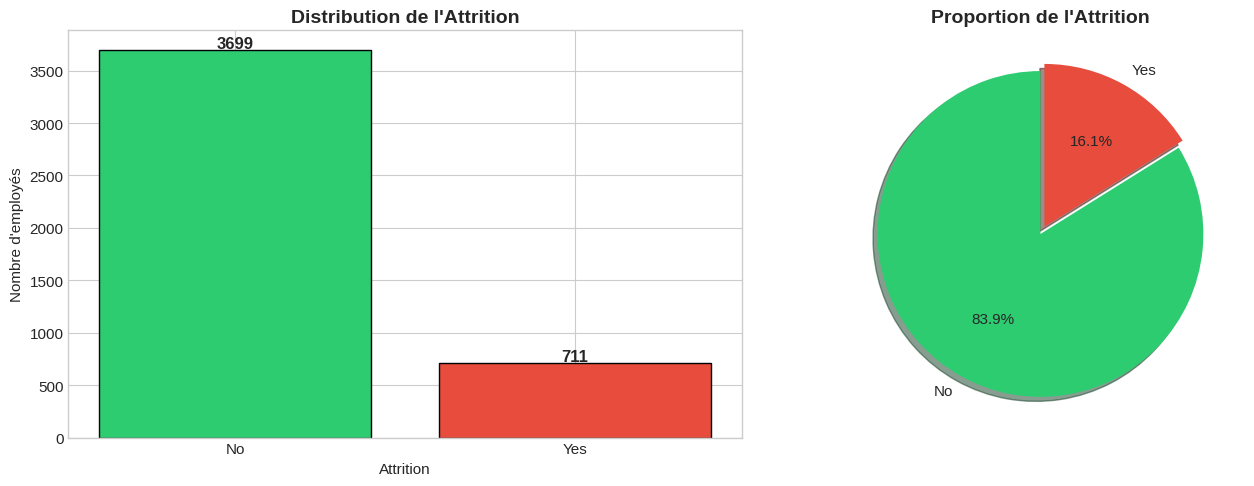


📊 Taux d'attrition: 16.12%
⚠️  Dataset déséquilibré - à prendre en compte pour le modèle


In [7]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Countplot
attrition_counts = df['Attrition'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(attrition_counts.index, attrition_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribution de l\'Attrition', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Attrition')
axes[0].set_ylabel('Nombre d\'employés')

# Ajout des valeurs sur les barres
for i, (idx, val) in enumerate(zip(attrition_counts.index, attrition_counts.values)):
    axes[0].text(idx, val + 20, str(val), ha='center', fontsize=12, fontweight='bold')

# Pie chart
axes[1].pie(attrition_counts.values, labels=attrition_counts.index, autopct='%1.1f%%',
            colors=colors, explode=(0, 0.05), shadow=True, startangle=90)
axes[1].set_title('Proportion de l\'Attrition', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Stats
attrition_rate = (df['Attrition'] == 'Yes').mean() * 100
print(f"\n📊 Taux d'attrition: {attrition_rate:.2f}%")
print(f"⚠️  Dataset déséquilibré - à prendre en compte pour le modèle")

### 2.2 Heatmap de corrélation bivariée

Visualisons les corrélations entre les variables numériques.

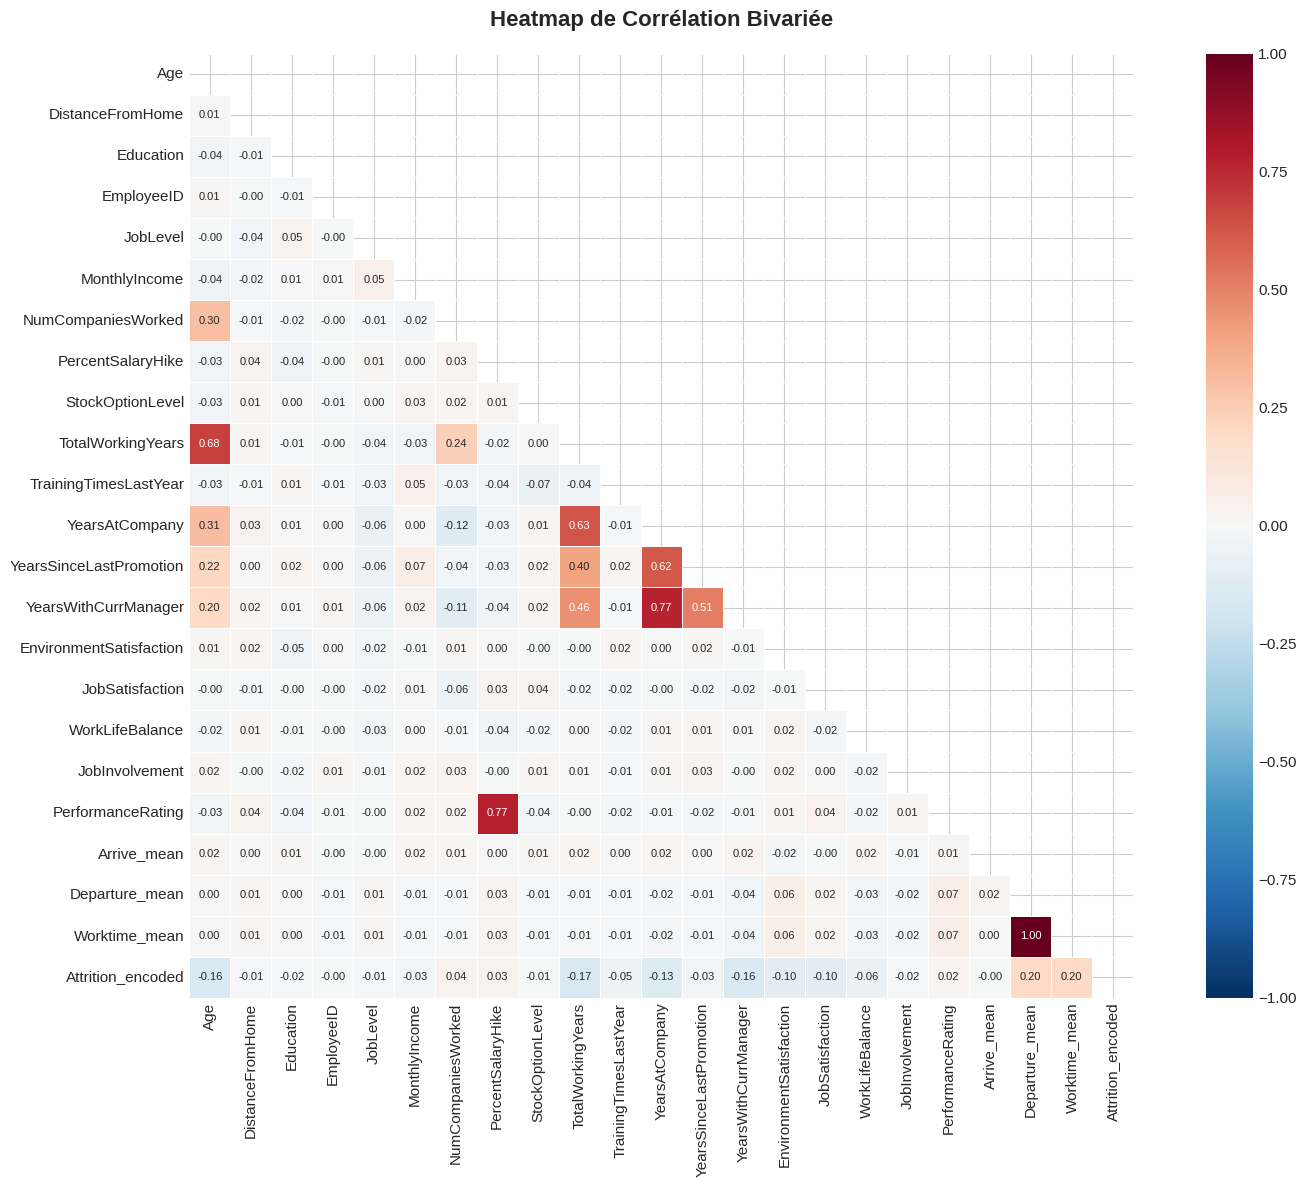


📈 Top 10 corrélations avec Attrition:
  + Worktime_mean: 0.202
  + Departure_mean: 0.202
  - TotalWorkingYears: 0.170
  - Age: 0.159
  - YearsWithCurrManager: 0.156
  - YearsAtCompany: 0.134
  - JobSatisfaction: 0.103
  - EnvironmentSatisfaction: 0.102
  - WorkLifeBalance: 0.063
  - TrainingTimesLastYear: 0.049


In [8]:
# Encodage temporaire de Attrition pour la corrélation
df_corr = df.copy()
df_corr['Attrition_encoded'] = (df_corr['Attrition'] == 'Yes').astype(int)

# Sélection des colonnes numériques
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# Matrice de corrélation
correlation_matrix = df_corr[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, linewidths=0.5,
            annot_kws={'size': 8}, vmin=-1, vmax=1)
plt.title('Heatmap de Corrélation Bivariée', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top corrélations avec Attrition
print("\n📈 Top 10 corrélations avec Attrition:")
attrition_corr = correlation_matrix['Attrition_encoded'].drop('Attrition_encoded').abs().sort_values(ascending=False)
for col, corr in attrition_corr.head(10).items():
    direction = '+' if correlation_matrix.loc[col, 'Attrition_encoded'] > 0 else '-'
    print(f"  {direction} {col}: {corr:.3f}")

### 2.3 Distribution des variables numériques

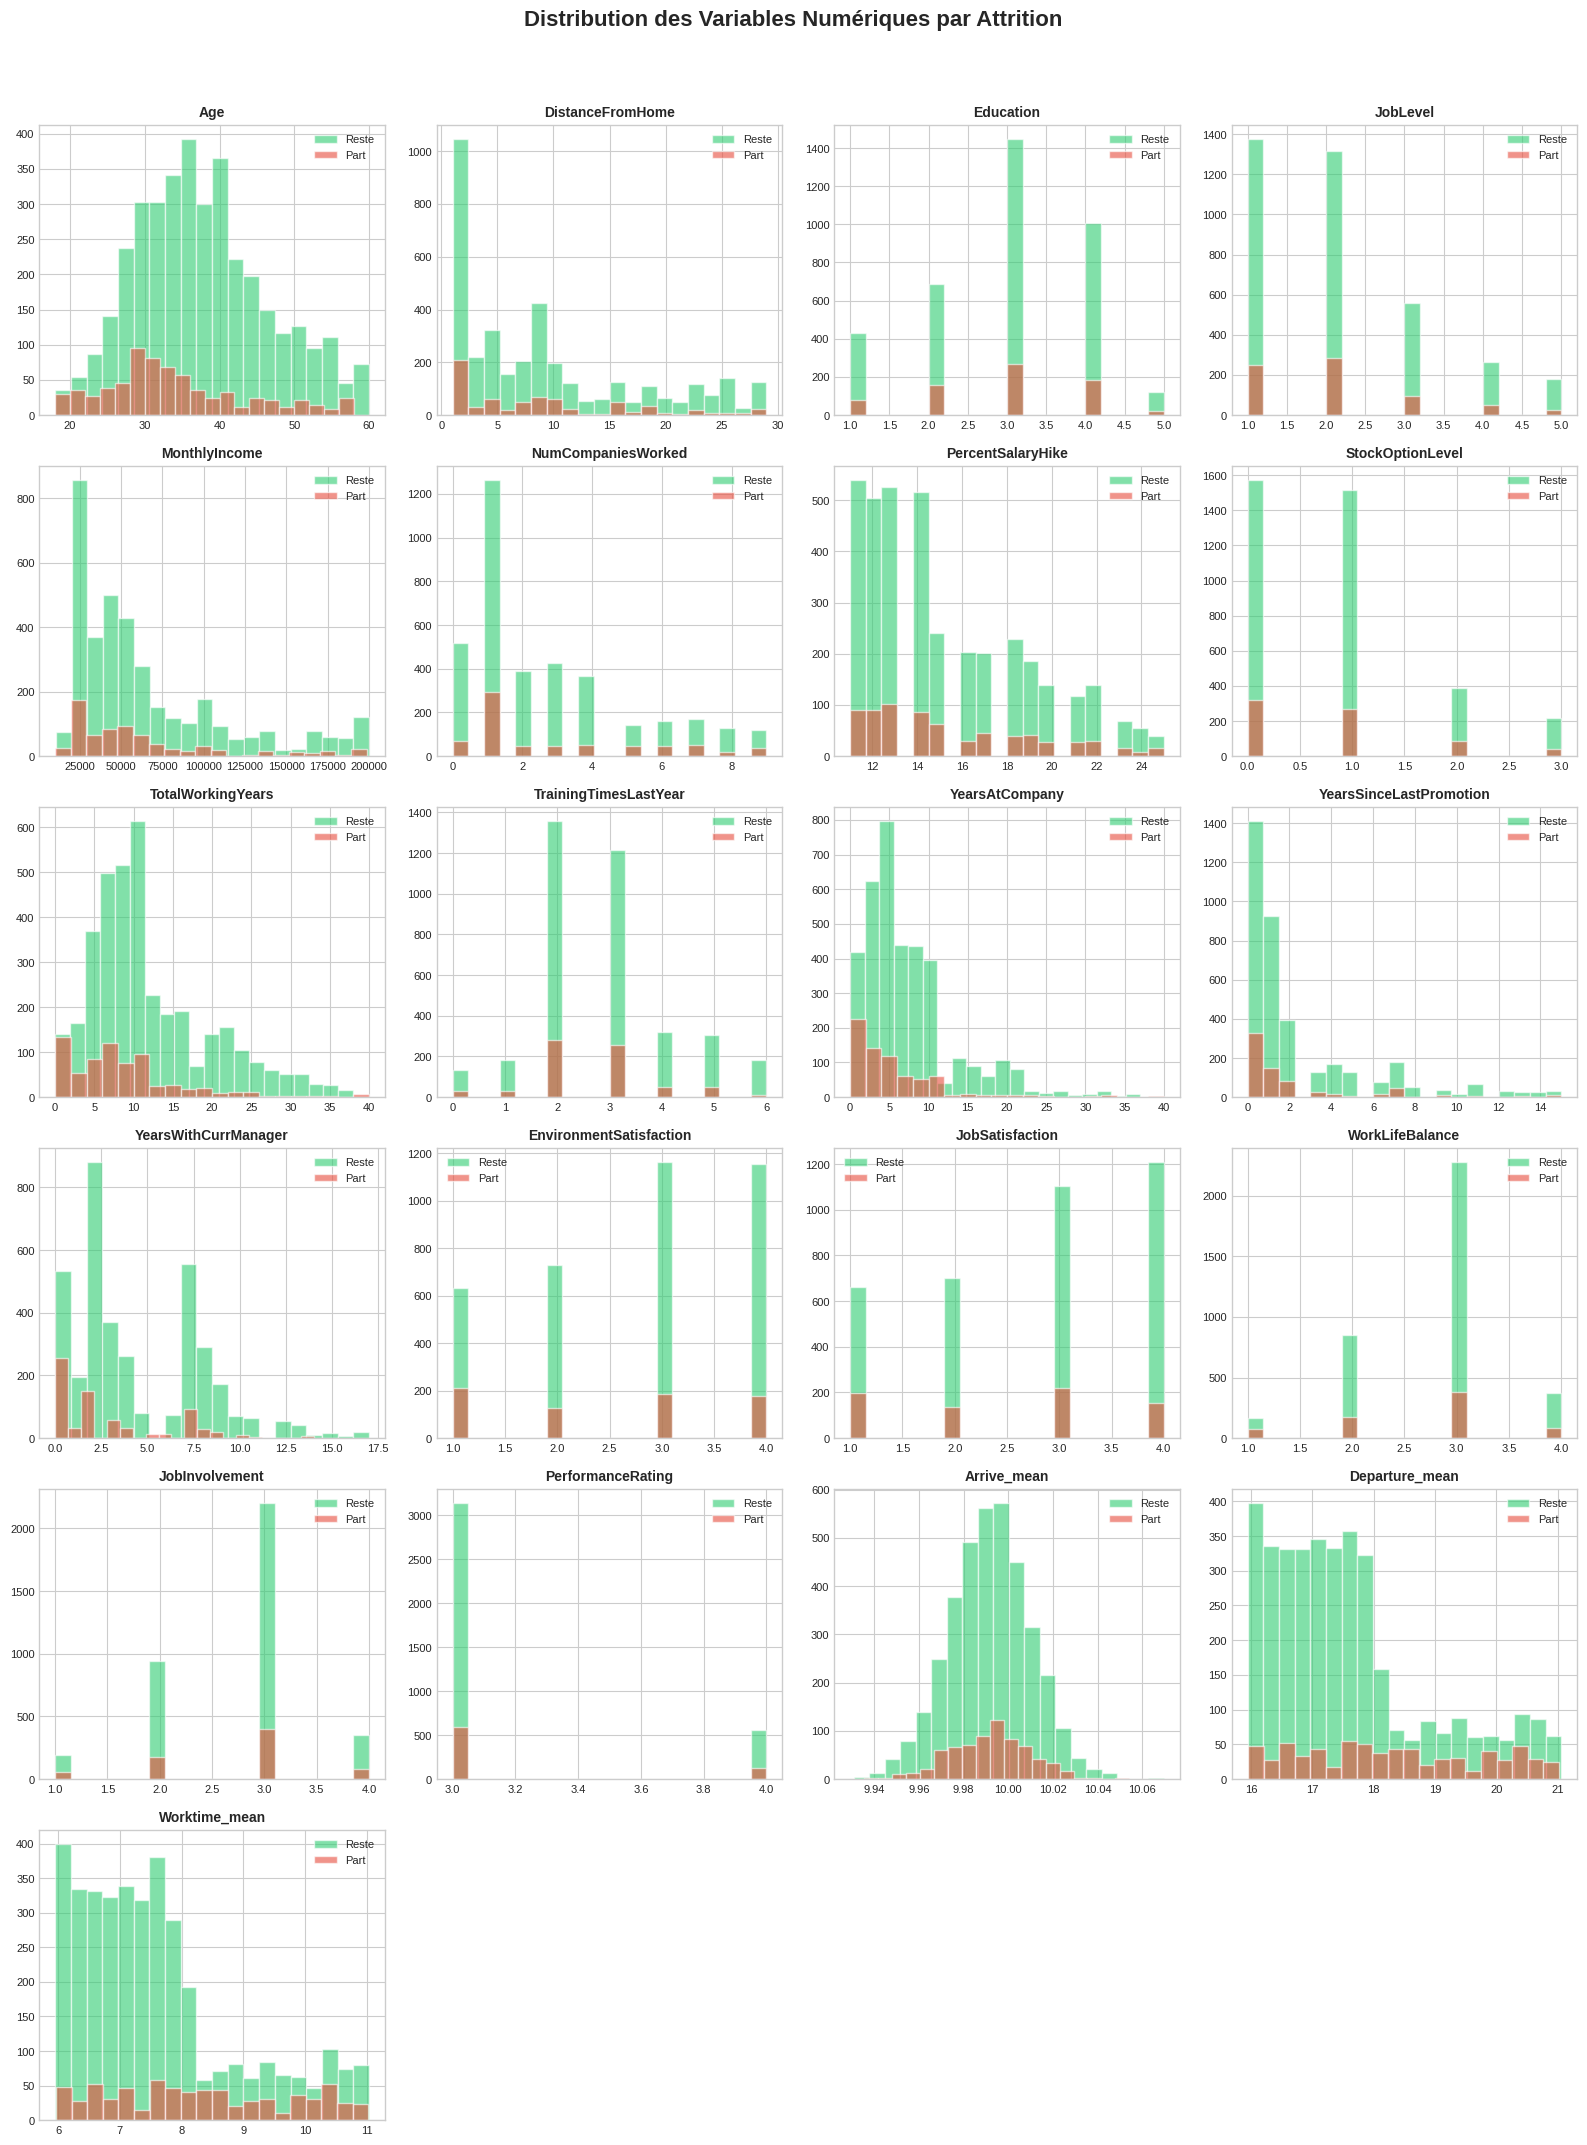

In [9]:
# Variables numériques à visualiser (exclure IDs)
numeric_features = [col for col in numeric_cols if 'ID' not in col and 'encoded' not in col]

# Calcul du nombre de lignes nécessaires
n_cols = 4
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    
    # Histogramme par Attrition
    for attrition_val, color, label in [('No', '#2ecc71', 'Reste'), ('Yes', '#e74c3c', 'Part')]:
        data = df[df['Attrition'] == attrition_val][col].dropna()
        ax.hist(data, bins=20, alpha=0.6, color=color, label=label, edgecolor='white')
    
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.tick_params(labelsize=8)

# Masquer les axes vides
for idx in range(len(numeric_features), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribution des Variables Numériques par Attrition', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 2.4 Distribution des variables catégorielles

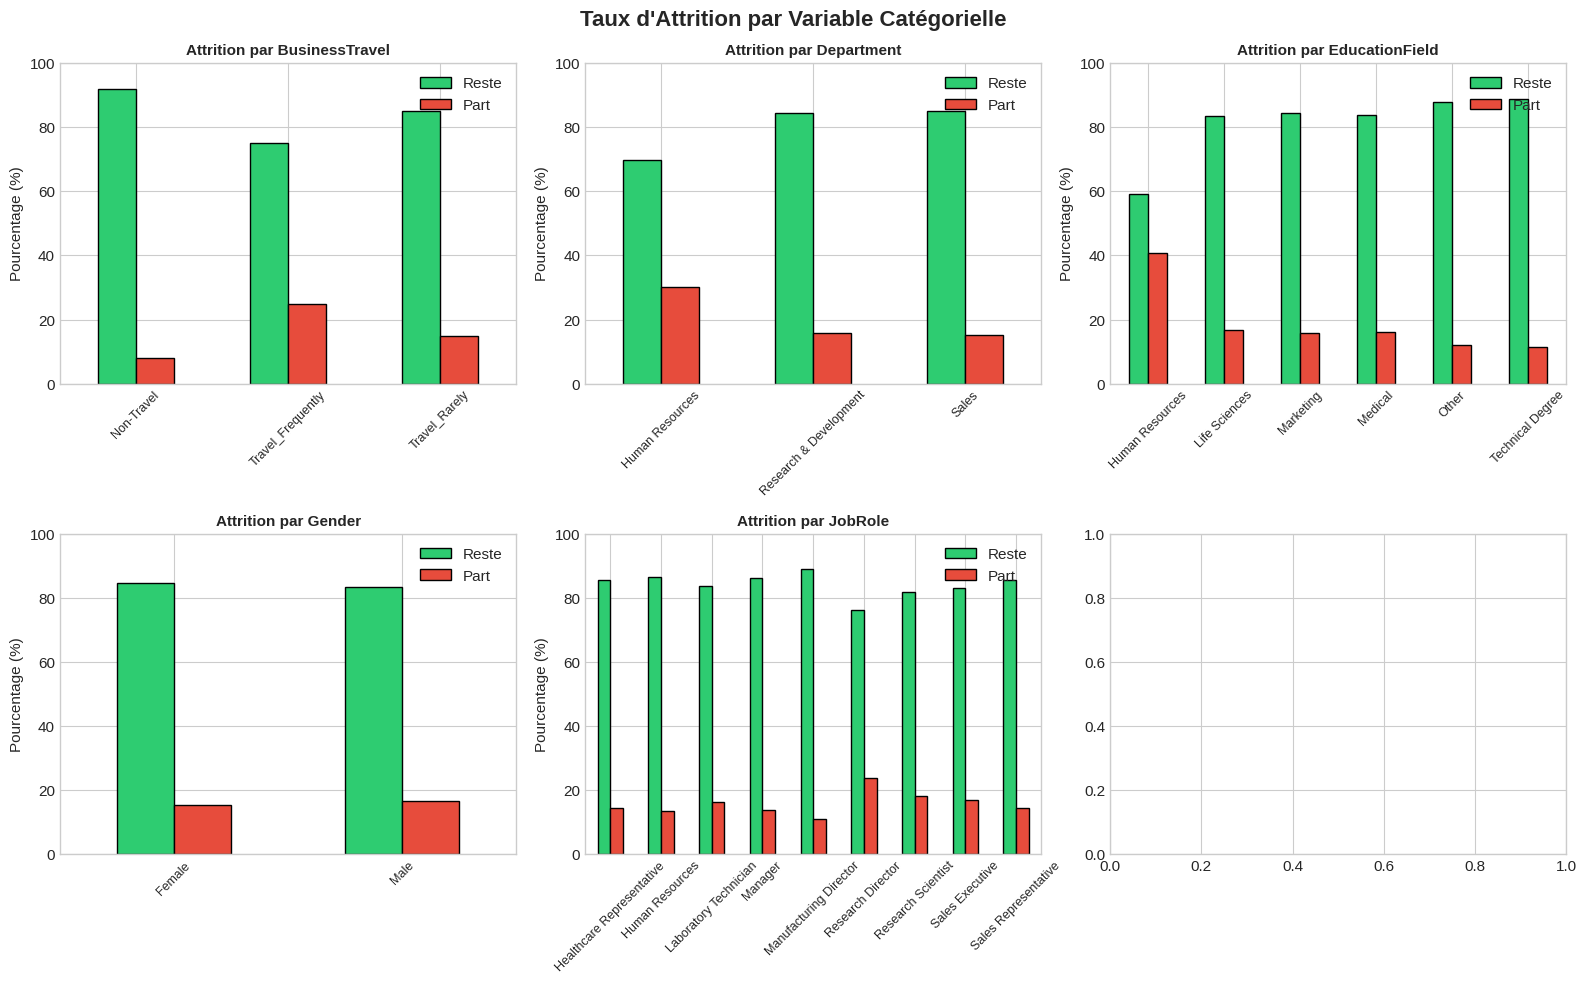

In [10]:
# Variables catégorielles
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Attrition']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols[:6]):
    ax = axes[idx]
    
    # Calcul des proportions d'attrition par catégorie
    cross_tab = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    
    cross_tab.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], edgecolor='black')
    ax.set_title(f'Attrition par {col}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Pourcentage (%)')
    ax.legend(['Reste', 'Part'], loc='upper right')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.set_ylim(0, 100)

plt.suptitle('Taux d\'Attrition par Variable Catégorielle', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
# 3️ Nettoyage des Données

Étapes de nettoyage :
1. Retrait des colonnes problématiques (colinéarité, RGPD, éthique, leakage)
2. Imputation des valeurs manquantes

### 3.1 Analyse des valeurs manquantes

📊 Colonnes avec valeurs manquantes:


,Missing,Percentage
WorkLifeBalance,38,0.861678
EnvironmentSatisfaction,25,0.566893
JobSatisfaction,20,0.453515
NumCompaniesWorked,19,0.430839
TotalWorkingYears,9,0.204082


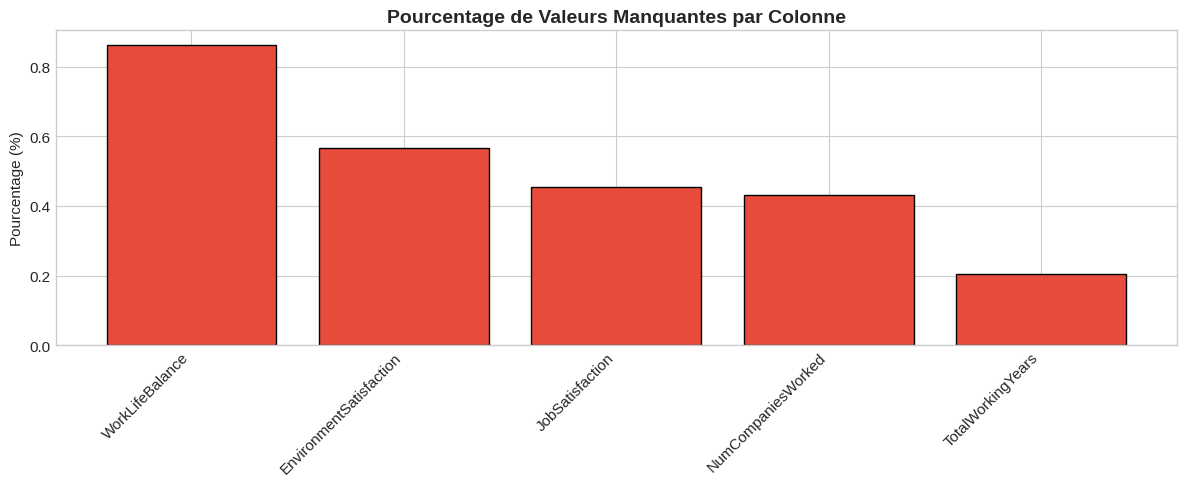

In [11]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    print("📊 Colonnes avec valeurs manquantes:")
    display(missing_df)
    
    # Visualisation
    plt.figure(figsize=(12, 5))
    plt.bar(missing_df.index, missing_df['Percentage'], color='#e74c3c', edgecolor='black')
    plt.title('Pourcentage de Valeurs Manquantes par Colonne', fontsize=14, fontweight='bold')
    plt.ylabel('Pourcentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("✅ Aucune valeur manquante dans le dataset!")

### 3.2 Identification et retrait des colonnes problématiques

**Critères de suppression :**
- **Colinéarité** : Variables fortement corrélées entre elles (redondance)
- **Non-conformité RGPD** : Données personnelles sensibles
- **Éthique** : Variables potentiellement discriminatoires
- **Leakage** : Variables qui fuiteraient l'information cible
- **Non pertinence** : Variables sans pouvoir prédictif

In [12]:
# Colonnes à supprimer avec justification
columns_to_drop = {
    'EmployeeID': 'Non pertinent - Identifiant unique sans valeur prédictive',
    'Gender': 'Éthique - Potentiellement discriminatoire (biais de genre)',
    'Over18': 'Non pertinent - Valeur constante (tous > 18 ans)',
    'StandardHours': 'Non pertinent - Valeur constante (80h pour tous)',
    'EmployeeCount': 'Non pertinent - Valeur constante (1 pour tous)',
    'Departure_mean': 'Trop corrélé avec worktime mean',
    'Age': "Ethique - discrimination sur l'age",
    'MaritalStatus': 'Éthique - Information personnelle potentiellement discriminatoire'
}

# Vérifier les colonnes qui existent réellement
existing_cols_to_drop = [col for col in columns_to_drop.keys() if col in df.columns]

print("🗑️ Colonnes à supprimer:")
print("=" * 70)
for col in existing_cols_to_drop:
    reason = columns_to_drop[col]
    print(f"  • {col}: {reason}")

# Suppression des colonnes
df_clean = df.drop(columns=existing_cols_to_drop, errors='ignore')

print(f"\n✅ Colonnes supprimées: {len(existing_cols_to_drop)}")
print(f"📊 Shape après suppression: {df_clean.shape}")

🗑️ Colonnes à supprimer:
  • EmployeeID: Non pertinent - Identifiant unique sans valeur prédictive
  • Gender: Éthique - Potentiellement discriminatoire (biais de genre)
  • Departure_mean: Trop corrélé avec worktime mean
  • Age: Ethique - discrimination sur l'age

✅ Colonnes supprimées: 4
📊 Shape après suppression: (4410, 24)


### 3.3 Détection et traitement de la colinéarité

In [13]:
numeric_cols_clean = df_clean.select_dtypes(include=[np.number]).columns.tolist()

print("📊 Colonnes numériques disponibles:")
print(f"   {numeric_cols_clean}")
print("\n⏭️ L'analyse de colinéarité sera effectuée après le split (section 4.3)")

📊 Colonnes numériques disponibles:
   ['DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Arrive_mean', 'Worktime_mean']

⏭️ L'analyse de colinéarité sera effectuée après le split (section 4.3)


### 3.4 Affichage du DataFrame final nettoyé

In [14]:
print("=" * 70)
print("DATAFRAME FINAL NETTOYÉ")
print("=" * 70)
print(f"\nShape: {df_clean.shape}")
print(f"\nColonnes ({len(df_clean.columns)}):")

# Séparer numériques et catégorielles
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\n  📊 Numériques ({len(num_cols)}): {num_cols}")
print(f"\n  📝 Catégorielles ({len(cat_cols)}): {cat_cols}")

display(df_clean.head(10))

print("\n📈 Statistiques descriptives:")
display(df_clean.describe())

DATAFRAME FINAL NETTOYÉ

Shape: (4410, 24)

Colonnes (24):

  📊 Numériques (19): ['DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Arrive_mean', 'Worktime_mean']

  📝 Catégorielles (5): ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'JobRole']


,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Arrive_mean,Worktime_mean
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,1,0,0,3.0,4.0,2.0,3,3,9.993032,7.374138
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,5,1,4,3.0,2.0,4.0,2,4,9.980720,7.717726
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,5,0,3,2.0,2.0,1.0,3,3,10.016598,7.013499
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,8,7,5,4.0,4.0,3.0,2,3,9.973830,7.193475
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,6,0,4,4.0,1.0,3.0,3,3,9.990068,8.006259
5,No,Travel_Rarely,Research & Development,8,3,Life Sciences,4,Research Director,40710,3.0,...,7,7,7,3.0,2.0,2.0,3,3,9.980450,10.796062
6,Yes,Travel_Rarely,Research & Development,11,2,Medical,2,Sales Executive,58130,2.0,...,0,0,0,1.0,3.0,1.0,3,4,9.956250,6.923060
7,No,Travel_Rarely,Research & Development,18,3,Life Sciences,2,Sales Executive,31430,2.0,...,0,0,0,1.0,2.0,3.0,3,4,9.994102,6.725514
8,No,Travel_Rarely,Research & Development,1,3,Life Sciences,3,Laboratory Technician,20440,0.0,...,9,7,8,2.0,4.0,3.0,3,4,10.013841,7.236884
9,No,Non-Travel,Research & Development,7,4,Medical,4,Laboratory Technician,134640,1.0,...,6,1,5,2.0,1.0,3.0,3,3,9.956838,7.079630



📈 Statistiques descriptives:


,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Arrive_mean,Worktime_mean
count,4410.000000,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,9.192517,2.912925,2.063946,65029.312925,2.694830,15.209524,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741,9.991773,7.700785
std,8.105026,1.023933,1.106689,47068.888559,2.498887,3.659108,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742,0.018147,1.340209
min,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,9.929079,5.950881
25%,2.000000,2.000000,1.000000,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,9.979616,6.673153
50%,7.000000,3.000000,2.000000,49190.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,9.991957,7.406863
75%,14.000000,4.000000,3.000000,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,10.003581,8.368289
max,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.069684,11.031410


---
# 4️ Pipeline Machine Learning

Construction du pipeline complet :
1. Préparation des features et target
2. Split train/test/validation
3. Preprocessing (encoding + standardisation)
4. Définition des modèles et hyperparamètres
5. Tuning et entraînement
6. Comparaison et sélection du meilleur modèle

### 4.1 Préparation des features et target

In [15]:
# Séparation features / target
X = df_clean.drop(columns=['Attrition'])
y = (df_clean['Attrition'] == 'Yes').astype(int)  # 1 = Part, 0 = Reste

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nDistribution target:")
print(y.value_counts())

Features shape: (4410, 23)
Target shape: (4410,)

Distribution target:
Attrition
0    3699
1     711
Name: count, dtype: int64


### 4.2 Split Train / Test / Validation

- **Train** : 70% - Pour l'entraînement des modèles
- **Test** : 15% - Pour l'évaluation finale
- **Validation** : 15% - Pour l'analyse approfondie

In [16]:
# Shuffle et split
# Premier split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y, shuffle=True
)

# Second split: 50/50 pour test et validation (15% chacun du total)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp, shuffle=True
)

print("📊 Répartition des données:")
print(f"  • Train:      {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Test:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  • Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")

print("\n📈 Distribution de la cible par set:")
for name, y_set in [('Train', y_train), ('Test', y_test), ('Validation', y_val)]:
    pct_pos = y_set.mean() * 100
    print(f"  • {name}: {pct_pos:.1f}% d'attrition")

📊 Répartition des données:
  • Train:      3087 samples (70.0%)
  • Test:       661 samples (15.0%)
  • Validation: 662 samples (15.0%)

📈 Distribution de la cible par set:
  • Train: 16.1% d'attrition
  • Test: 16.0% d'attrition
  • Validation: 16.2% d'attrition


In [17]:
print("=" * 70)
print("ANALYSE DE COLINÉARITÉ (SUR TRAIN UNIQUEMENT)")
print("=" * 70)

# ⚠️ IMPORTANT: Analyse UNIQUEMENT sur le training set
numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Créer un DataFrame temporaire pour l'analyse
X_train_corr = X_train[numeric_cols_train].copy()
y_train_temp = y_train.copy()

# Matrice de corrélation
corr_matrix = X_train_corr.corr().abs()

# Trouver les paires fortement corrélées (> 0.85)
threshold = 0.85
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = []
for col in upper_tri.columns:
    for idx in upper_tri.index:
        if upper_tri.loc[idx, col] > threshold:
            high_corr_pairs.append((idx, col, upper_tri.loc[idx, col]))

cols_to_remove_collinearity = set()

if high_corr_pairs:
    print(f"\n⚠️ Paires avec corrélation > {threshold}:")
    
    # Ajouter y à X_train_corr temporairement pour calculer corrélation avec target
    X_train_with_target = X_train_corr.copy()
    X_train_with_target['Attrition_num'] = y_train_temp.values
    
    for var1, var2, corr in high_corr_pairs:
        print(f"  • {var1} ↔ {var2}: {corr:.3f}")
        
        # Calculer corrélation avec la cible
        corr1 = abs(X_train_with_target[var1].corr(X_train_with_target['Attrition_num']))
        corr2 = abs(X_train_with_target[var2].corr(X_train_with_target['Attrition_num']))
        
        # Supprimer celle avec moins de corrélation avec la cible
        to_remove = var1 if corr1 < corr2 else var2
        cols_to_remove_collinearity.add(to_remove)
        print(f"    → Suppression de '{to_remove}' (corr avec target: {min(corr1, corr2):.3f})")
    
    # Supprimer les colonnes identifiées des 3 sets
    if cols_to_remove_collinearity:
        print(f"\n🗑️ Suppression de {len(cols_to_remove_collinearity)} colonnes colinéaires:")
        for col in cols_to_remove_collinearity:
            print(f"  • {col}")
        
        X_train = X_train.drop(columns=list(cols_to_remove_collinearity), errors='ignore')
        X_test = X_test.drop(columns=list(cols_to_remove_collinearity), errors='ignore')
        X_val = X_val.drop(columns=list(cols_to_remove_collinearity), errors='ignore')
        
        print(f"\n✅ Nouvelle shape après suppression colinéarité:")
        print(f"   Train: {X_train.shape}")
        print(f"   Test:  {X_test.shape}")
        print(f"   Val:   {X_val.shape}")
else:
    print("\n✅ Aucune colinéarité forte détectée sur le training set.")

ANALYSE DE COLINÉARITÉ (SUR TRAIN UNIQUEMENT)

✅ Aucune colinéarité forte détectée sur le training set.


### 4.3 Pipeline de Preprocessing (Encoding + Standardisation)

In [18]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print("📊 Features après suppression colinéarité:")
print(f"\nNumériques ({len(numeric_features)}): {numeric_features}")
print(f"\nCatégorielles ({len(categorical_features)}): {categorical_features}")

# Pipeline de preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # ✅ Imputation sur train
    ('scaler', StandardScaler())                     # ✅ Scaling sur train
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # ✅ Imputation sur train
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ✅ Fit sur train, transform sur test/val
X_train_processed = preprocessor.fit_transform(X_train)  # fit_transform sur train
X_test_processed = preprocessor.transform(X_test)        # transform sur test
X_val_processed = preprocessor.transform(X_val)          # transform sur val

# Récupération des noms de features après encoding
cat_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features).tolist()
all_feature_names = numeric_features + cat_feature_names

print(f"\n✅ Preprocessing terminé!")
print(f"   Shape après transformation:")
print(f"   • Train: {X_train_processed.shape}")
print(f"   • Test:  {X_test_processed.shape}")
print(f"   • Val:   {X_val_processed.shape}")
print(f"   Nombre total de features: {len(all_feature_names)}")
print(f"\n🎯 AUCUN DATA LEAKAGE - Toutes les opérations basées sur TRAIN uniquement!")

📊 Features après suppression colinéarité:

Numériques (19): ['DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Arrive_mean', 'Worktime_mean']

Catégorielles (4): ['BusinessTravel', 'Department', 'EducationField', 'JobRole']

✅ Preprocessing terminé!
   Shape après transformation:
   • Train: (3087, 40)
   • Test:  (661, 40)
   • Val:   (662, 40)
   Nombre total de features: 40

🎯 AUCUN DATA LEAKAGE - Toutes les opérations basées sur TRAIN uniquement!


### 4.4 Application de SMOTE pour équilibrer les classes

**SMOTE (Synthetic Minority Over-sampling Technique)** génère des exemples synthétiques de la classe minoritaire.

⚠️ **Important** : SMOTE est appliqué **uniquement sur les données d'entraînement** pour éviter le data leakage.


In [19]:
# Application de SMOTE sur le training set uniquement
print("📊 Distribution AVANT SMOTE:")
print(f"  Classe 0 (reste): {(y_train == 0).sum()} samples ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Classe 1 (départ): {(y_train == 1).sum()} samples ({(y_train == 1).mean()*100:.1f}%)")

# Initialiser SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

# Appliquer SMOTE sur les données d'entraînement prétraitées
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\n📊 Distribution APRÈS SMOTE:")
print(f"  Classe 0 (reste): {(y_train_resampled == 0).sum()} samples ({(y_train_resampled == 0).mean()*100:.1f}%)")
print(f"  Classe 1 (départ): {(y_train_resampled == 1).sum()} samples ({(y_train_resampled == 1).mean()*100:.1f}%)")

print(f"\n✅ SMOTE appliqué avec succès!")
print(f"  • Nombre de samples avant: {len(y_train)}")
print(f"  • Nombre de samples après: {len(y_train_resampled)}")
print(f"  • Augmentation: +{len(y_train_resampled) - len(y_train)} samples")

# Note: X_test_processed et X_val_processed restent inchangés (pas de SMOTE)


📊 Distribution AVANT SMOTE:
  Classe 0 (reste): 2589 samples (83.9%)
  Classe 1 (départ): 498 samples (16.1%)

📊 Distribution APRÈS SMOTE:
  Classe 0 (reste): 2589 samples (50.0%)
  Classe 1 (départ): 2589 samples (50.0%)

✅ SMOTE appliqué avec succès!
  • Nombre de samples avant: 3087
  • Nombre de samples après: 5178
  • Augmentation: +2091 samples


### 4.4 Définition des Modèles et Hyperparamètres

In [20]:
# Définition des modèles et leurs grilles d'hyperparamètres
models_config = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'class_weight': [None, 'balanced']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced']
        }
    },
    'Perceptron': {
        'model': Perceptron(random_state=RANDOM_STATE),
        'params': {
            'penalty': [None, 'l2', 'l1', 'elasticnet'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'max_iter': [500, 1000, 2000],
            'class_weight': [None, 'balanced']
        }
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_depth': [3, 5, 7, None],
            'min_samples_leaf': [10, 20, 30],
            'l2_regularization': [0, 0.1, 1.0],
            'class_weight': [None, 'balanced']  # Ajout de class_weight (disponible depuis sklearn 1.2)
        }
    }
}

print("📋 Modèles configurés:")
for name, config in models_config.items():
    n_combinations = 1
    for param_values in config['params'].values():
        n_combinations *= len(param_values)
    print(f"  • {name}: {n_combinations} combinaisons d'hyperparamètres")

📋 Modèles configurés:
  • Logistic Regression: 48 combinaisons d'hyperparamètres
  • Random Forest: 216 combinaisons d'hyperparamètres
  • Perceptron: 96 combinaisons d'hyperparamètres
  • HistGradientBoosting: 864 combinaisons d'hyperparamètres


### 4.5 Tuning des Hyperparamètres et Entraînement

In [21]:
# Stockage des résultats
results = {}
best_models = {}

print("🚀 Lancement du tuning des hyperparamètres...\n")
print("=" * 70)

for model_name, config in models_config.items():
    print(f"\n📊 {model_name}")
    print("-" * 50)
    
    # GridSearchCV avec cross-validation
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='recall',  # Priorité au recall pour ne pas manquer de départs
        n_jobs=-1,
        verbose=0
    )
    
    # Fit
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Meilleur modèle
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    
    # Prédictions sur test
    y_pred = best_model.predict(X_test_processed)
    y_proba = best_model.predict_proba(X_test_processed)[:, 1] if hasattr(best_model, 'predict_proba') else None
    
    # Métriques
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'f2': fbeta_score(y_test, y_pred, beta=2),  # F2 donne plus de poids au recall
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_
    }
    results[model_name] = metrics
    
    # Affichage
    print(f"  Best CV Recall Score: {metrics['cv_score']:.4f}")
    print(f"  Test Accuracy:    {metrics['accuracy']:.4f}")
    print(f"  Test Precision:   {metrics['precision']:.4f}")
    print(f"  Test Recall:      {metrics['recall']:.4f}")
    print(f"  Test F1:          {metrics['f1']:.4f}")
    if metrics['roc_auc']:
        print(f"  Test ROC AUC:     {metrics['roc_auc']:.4f}")
    print(f"  Best params: {metrics['best_params']}")

print("\n" + "=" * 70)
print("✅ Tuning terminé!")

🚀 Lancement du tuning des hyperparamètres...


📊 Logistic Regression
--------------------------------------------------
  Best CV Recall Score: 0.7930
  Test Accuracy:    0.7262
  Test Precision:   0.3469
  Test Recall:      0.8019
  Test F1:          0.4843
  Test ROC AUC:     0.8264
  Best params: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}

📊 Random Forest
--------------------------------------------------
  Best CV Recall Score: 0.9826
  Test Accuracy:    0.9834
  Test Precision:   0.9612
  Test Recall:      0.9340
  Test F1:          0.9474
  Test ROC AUC:     0.9932
  Best params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

📊 Perceptron
--------------------------------------------------
  Best CV Recall Score: 0.7497
  Test Accuracy:    0.7700
  Test Precision:   0.2909
  Test Recall:      0.3019
  Test F1:          0.2963
  Best params: {'alpha': 0.01, 'class_weight': None, 'max_iter': 500

### 4.6 Graphiques Comparatifs des Modèles

In [22]:
# DataFrame des résultats

from pandas.io.formats.style import Styler
results_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1 Score': [r['f1'] for r in results.values()],
    'ROC AUC': [r['roc_auc'] if r['roc_auc'] else 0 for r in results.values()],
    'CV F1': [r['cv_score'] for r in results.values()]
}).set_index('Model')

print("📊 Tableau comparatif des performances:")
display(results_df.style.highlight_max(axis=0, color='green'))

📊 Tableau comparatif des performances:


,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV F1
Model,,,,,,
Logistic Regression,0.726172,0.346939,0.801887,0.484330,0.826398,0.792975
Random Forest,0.983359,0.961165,0.933962,0.947368,0.993192,0.982624
Perceptron,0.770045,0.290909,0.301887,0.296296,0.000000,0.749749
HistGradientBoosting,0.980333,0.951456,0.924528,0.937799,0.989206,0.984942


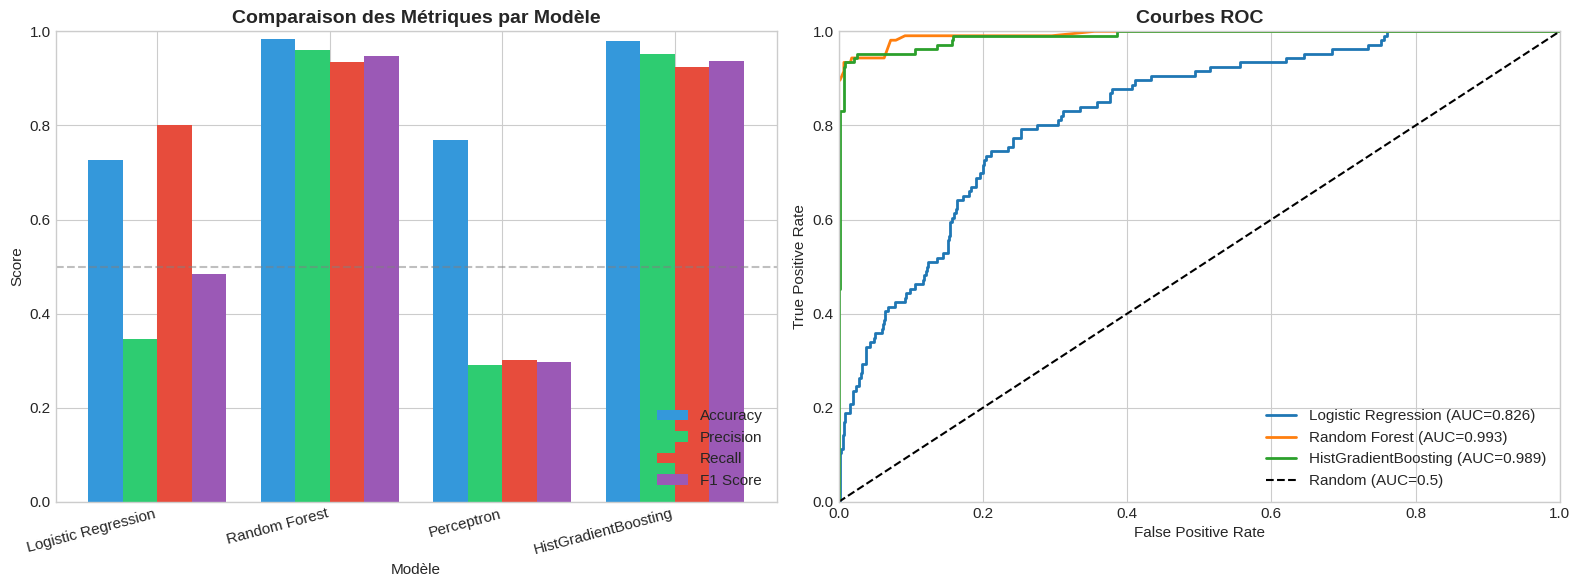

In [23]:
# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Barplot des métriques
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(results_df.index))
width = 0.2
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i * width, results_df[metric], width, label=metric, color=colors[i])

axes[0].set_xlabel('Modèle')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des Métriques par Modèle', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(results_df.index, rotation=15, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# 2. ROC Curves
for model_name, model in best_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_processed)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        axes[1].plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})', linewidth=2)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Courbes ROC', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

### 4.7 Choix du Meilleur Modèle

In [24]:
# Sélection du meilleur modèle basé sur F1 Score (équilibre precision/recall)
best_model_name = results_df['F1 Score'].idxmax()
best_model_final = best_models[best_model_name]
best_metrics = results[best_model_name]

print("🏆 MEILLEUR MODÈLE SÉLECTIONNÉ")
print("=" * 50)
print(f"\n  Modèle: {best_model_name}")
print(f"\n  Performances sur le set de test:")
print(f"    • Accuracy:  {best_metrics['accuracy']:.4f}")
print(f"    • Precision: {best_metrics['precision']:.4f}")
print(f"    • Recall:    {best_metrics['recall']:.4f}")
print(f"    • F1 Score:  {best_metrics['f1']:.4f}")
if best_metrics['roc_auc']:
    print(f"    • ROC AUC:   {best_metrics['roc_auc']:.4f}")
print(f"\n  Hyperparamètres optimaux:")
for param, value in best_metrics['best_params'].items():
    print(f"    • {param}: {value}")

🏆 MEILLEUR MODÈLE SÉLECTIONNÉ

  Modèle: Random Forest

  Performances sur le set de test:
    • Accuracy:  0.9834
    • Precision: 0.9612
    • Recall:    0.9340
    • F1 Score:  0.9474
    • ROC AUC:   0.9932

  Hyperparamètres optimaux:
    • class_weight: None
    • max_depth: None
    • min_samples_leaf: 1
    • min_samples_split: 2
    • n_estimators: 100


### 4.7 Optimisation du Seuil de Décision

**Objectif** : Ajuster le seuil pour maximiser le **recall** (ne pas manquer de départs).

Par défaut, sklearn utilise un seuil de 0.5. Nous allons trouver le seuil optimal qui favorise la détection des employés susceptibles de partir.


🎯 Optimisation du seuil de décision:
  • Seuil par défaut: 0.5
  • Seuil optimal:    0.540

📊 Métriques avec seuil optimal (0.540):
  • Recall:    0.9340
  • Precision: 0.9612
  • F2-score:  0.9393

📈 Matrice de confusion (seuil optimal 0.540):
[[551   4]
 [  7  99]]


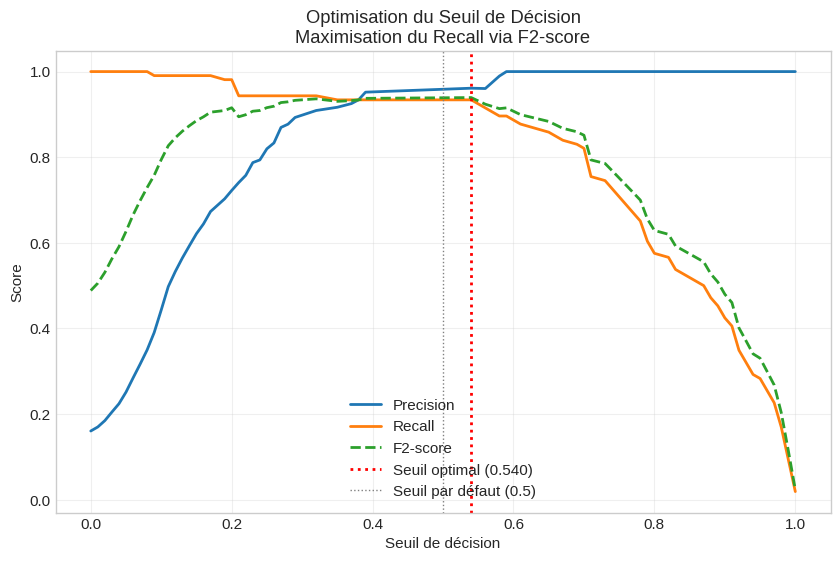


✅ Seuil optimal trouvé et sauvegardé: 0.540


In [25]:
# Obtenir les probabilités de prédiction
if hasattr(best_model_final, 'predict_proba'):
    y_test_proba = best_model_final.predict_proba(X_test_processed)[:, 1]
    
    # Calculer precision et recall pour différents seuils
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)
    
    # Trouver le seuil optimal en maximisant F2-score (priorité au recall)
    f2_scores = []
    for threshold in thresholds:
        y_pred_threshold = (y_test_proba >= threshold).astype(int)
        f2 = fbeta_score(y_test, y_pred_threshold, beta=2)
        f2_scores.append(f2)
    
    # Meilleur seuil basé sur F2-score
    optimal_idx = np.argmax(f2_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_precision = precisions[optimal_idx]
    optimal_recall = recalls[optimal_idx]
    optimal_f2 = f2_scores[optimal_idx]
    
    print("🎯 Optimisation du seuil de décision:")
    print(f"  • Seuil par défaut: 0.5")
    print(f"  • Seuil optimal:    {optimal_threshold:.3f}")
    print(f"\n📊 Métriques avec seuil optimal ({optimal_threshold:.3f}):")
    print(f"  • Recall:    {optimal_recall:.4f}")
    print(f"  • Precision: {optimal_precision:.4f}")
    print(f"  • F2-score:  {optimal_f2:.4f}")
    
    # Prédictions avec seuil optimal
    y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)
    
    # Matrice de confusion avec seuil optimal
    cm_optimal = confusion_matrix(y_test, y_test_pred_optimal)
    
    print(f"\n📈 Matrice de confusion (seuil optimal {optimal_threshold:.3f}):")
    print(cm_optimal)
    
    # Visualisation de la courbe Precision-Recall
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], label='Recall', linewidth=2)
    plt.plot(thresholds, f2_scores, label='F2-score', linewidth=2, linestyle='--')
    plt.axvline(optimal_threshold, color='red', linestyle=':', linewidth=2, label=f'Seuil optimal ({optimal_threshold:.3f})')
    plt.axvline(0.5, color='gray', linestyle=':', linewidth=1, label='Seuil par défaut (0.5)')
    plt.xlabel('Seuil de décision')
    plt.ylabel('Score')
    plt.title('Optimisation du Seuil de Décision\nMaximisation du Recall via F2-score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"\n✅ Seuil optimal trouvé et sauvegardé: {optimal_threshold:.3f}")
else:
    optimal_threshold = 0.5
    print("⚠️ Modèle ne supporte pas predict_proba, utilisation du seuil par défaut 0.5")


### 4.8 Sauvegarde du Modèle


In [26]:
# Sauvegarde du modèle et du preprocessor
model_filename = 'attrition_model.joblib'
preprocessor_filename = 'attrition_preprocessor.joblib'

joblib.dump(best_model_final, model_filename)
joblib.dump(preprocessor, preprocessor_filename)

print("💾 Modèle sauvegardé!")
print(f"  • Modèle:       {model_filename}")
print(f"  • Preprocessor: {preprocessor_filename}")

# Sauvegarde des métadonnées
metadata = {
    'model_name': best_model_name,
    'best_params': best_metrics['best_params'],
    'metrics': {
        'accuracy': best_metrics['accuracy'],
        'precision': best_metrics['precision'],
        'recall': best_metrics['recall'],
        'f1': best_metrics['f1'],
        'roc_auc': best_metrics['roc_auc']
    },
    'feature_names': all_feature_names,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'optimal_threshold': optimal_threshold,
    'smote_applied': True
}

joblib.dump(metadata, 'attrition_metadata.joblib')
print(f"  • Metadata:     attrition_metadata.joblib")



💾 Modèle sauvegardé!
  • Modèle:       attrition_model.joblib
  • Preprocessor: attrition_preprocessor.joblib
  • Metadata:     attrition_metadata.joblib


In [27]:
print("\n" + "=" * 70)
print("🔍 VALIDATION ANTI-LEAKAGE")
print("=" * 70)

# Test 1: Vérifier que les shapes sont cohérents
print("\n✅ Test 1: Cohérence des shapes")
print(f"   Train features: {X_train_processed.shape[1]}")
print(f"   Test features:  {X_test_processed.shape[1]}")
print(f"   Val features:   {X_val_processed.shape[1]}")
assert X_train_processed.shape[1] == X_test_processed.shape[1] == X_val_processed.shape[1], "❌ Shapes incohérents!"

# Test 2: Vérifier qu'il n'y a plus de valeurs manquantes
print("\n✅ Test 2: Valeurs manquantes après preprocessing")
print(f"   Train NaN: {np.isnan(X_train_processed).sum()}")
print(f"   Test NaN:  {np.isnan(X_test_processed).sum()}")
print(f"   Val NaN:   {np.isnan(X_val_processed).sum()}")

# Test 3: Vérifier que les moyennes/std sont différentes (preuve que pas d'overlap)
print("\n✅ Test 3: Statistiques des sets (doivent être légèrement différentes)")
print(f"   Train mean: {X_train_processed.mean():.4f}")
print(f"   Test mean:  {X_test_processed.mean():.4f}")
print(f"   Val mean:   {X_val_processed.mean():.4f}")

print("\n🎉 Tous les tests anti-leakage passés avec succès!")


🔍 VALIDATION ANTI-LEAKAGE

✅ Test 1: Cohérence des shapes
   Train features: 40
   Test features:  40
   Val features:   40

✅ Test 2: Valeurs manquantes après preprocessing
   Train NaN: 0
   Test NaN:  0
   Val NaN:   0

✅ Test 3: Statistiques des sets (doivent être légèrement différentes)
   Train mean: 0.1000
   Test mean:  0.1022
   Val mean:   0.0991

🎉 Tous les tests anti-leakage passés avec succès!


---
# 5️ Analyse Approfondie du Modèle

Analyse détaillée sur le set de validation pour comprendre les prédictions et les facteurs d'attrition.

### 5.1 Performance sur le Set de Validation

In [ ]:
# Prédictions sur validation AVEC SEUIL OPTIMAL
if hasattr(best_model_final, 'predict_proba'):
    y_val_proba = best_model_final.predict_proba(X_val_processed)[:, 1]
    # ✅ Application du seuil optimal
    y_val_pred = (y_val_proba >= optimal_threshold).astype(int)
    print(f"✅ Utilisation du seuil optimal: {optimal_threshold:.3f}")
else:
    y_val_pred = best_model_final.predict(X_val_processed)
    y_val_proba = None
    print("⚠️ Modèle sans predict_proba, utilisation de predict()")

print("📊 Performance sur le set de VALIDATION")
print("=" * 50)
print(f"\n{classification_report(y_val, y_val_pred, target_names=['Reste', 'Part'])}")

# Ajout des métriques détaillées
print("\n📈 Métriques détaillées avec seuil optimal:")
print(f"  • Accuracy:  {accuracy_score(y_val, y_val_pred):.4f}")
print(f"  • Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"  • Recall:    {recall_score(y_val, y_val_pred):.4f}")
print(f"  • F1 Score:  {f1_score(y_val, y_val_pred):.4f}")
print(f"  • F2 Score:  {fbeta_score(y_val, y_val_pred, beta=2):.4f}")

📊 Performance sur le set de VALIDATION

              precision    recall  f1-score   support

       Reste       0.99      1.00      0.99       555
        Part       0.98      0.95      0.97       107

    accuracy                           0.99       662
   macro avg       0.99      0.97      0.98       662
weighted avg       0.99      0.99      0.99       662



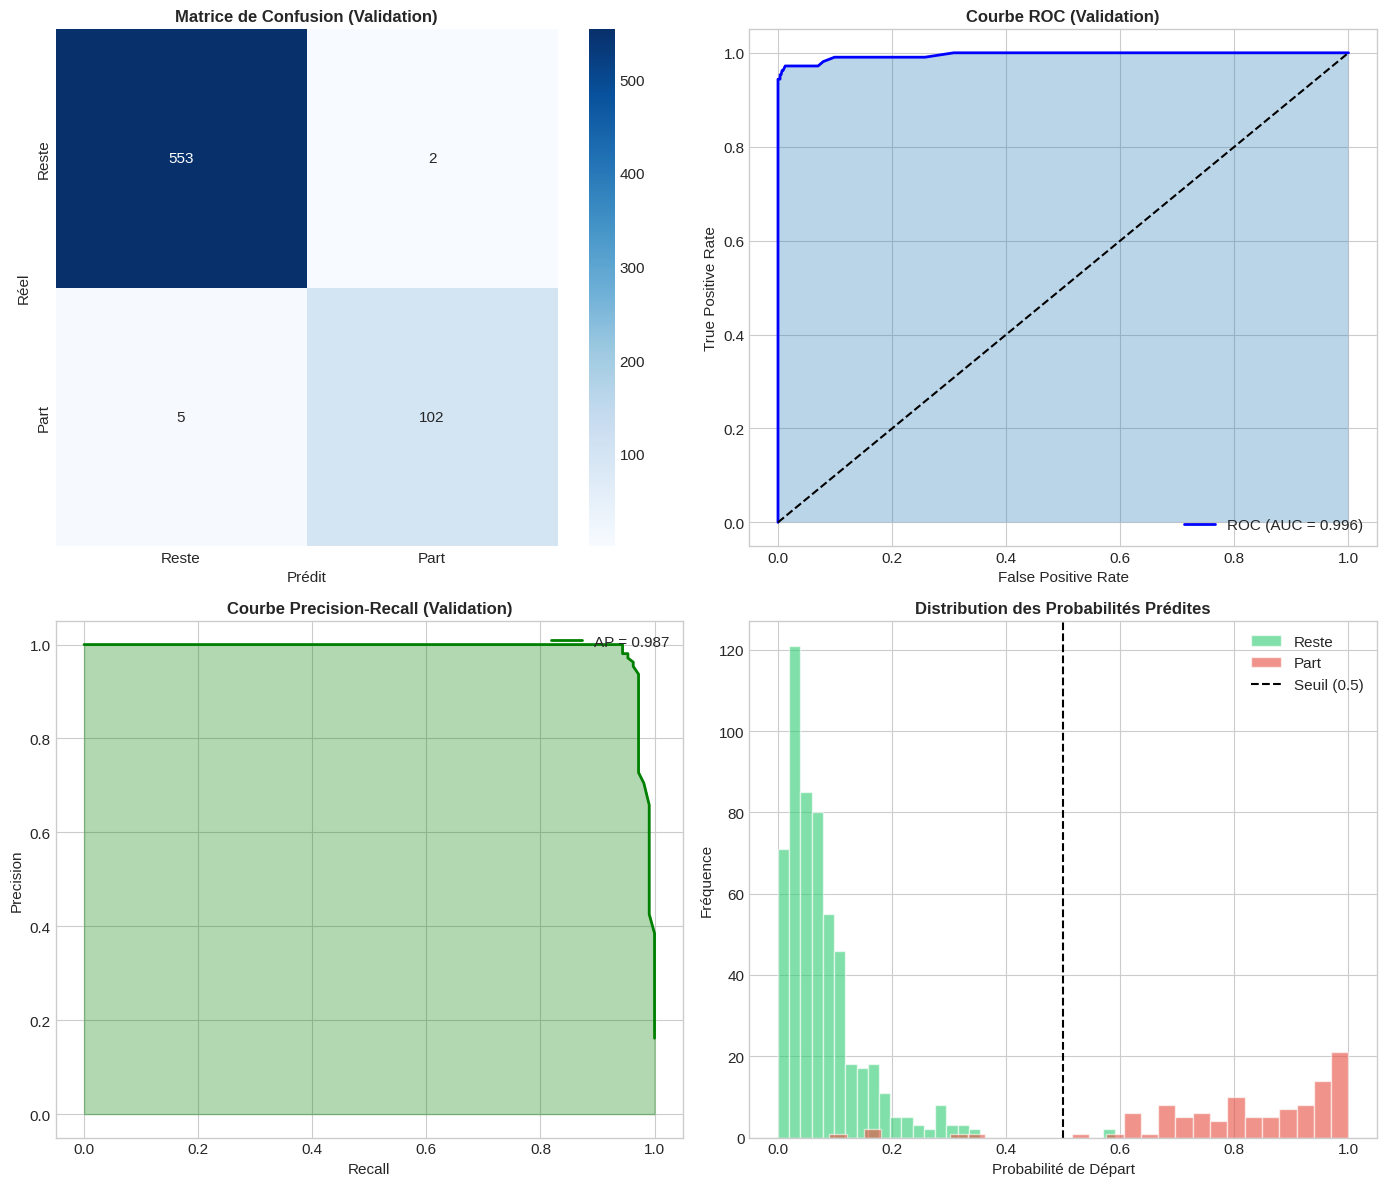

In [ ]:
# Visualisations avancées sur validation
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Matrice de confusion AVEC SEUIL OPTIMAL
cm = confusion_matrix(y_val, y_val_pred)  # y_val_pred utilise déjà le seuil optimal
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Reste', 'Part'], yticklabels=['Reste', 'Part'],
            cbar_kws={'label': 'Nombre'})
axes[0, 0].set_title(f'Matrice de Confusion (Validation)\nSeuil = {optimal_threshold:.3f}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Prédit')
axes[0, 0].set_ylabel('Réel')

# Ajout des pourcentages dans les cellules
for i in range(2):
    for j in range(2):
        text = axes[0, 0].text(j + 0.5, i + 0.7, 
                              f'({cm[i, j] / cm.sum() * 100:.1f}%)',
                              ha="center", va="center", color="gray", fontsize=9)

# 2. Courbe ROC (reste identique)
if y_val_proba is not None:
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_proba)
    auc = roc_auc_score(y_val, y_val_proba)
    axes[0, 1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {auc:.3f})')
    axes[0, 1].fill_between(fpr, tpr, alpha=0.3)
    axes[0, 1].plot([0, 1], [0, 1], 'k--')
    
    # Marquer le point correspondant au seuil optimal
    optimal_idx_roc = np.argmin(np.abs(thresholds_roc - optimal_threshold))
    axes[0, 1].scatter(fpr[optimal_idx_roc], tpr[optimal_idx_roc], 
                      color='red', s=100, zorder=5, 
                      label=f'Seuil optimal ({optimal_threshold:.3f})')
    
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('Courbe ROC (Validation)', fontsize=12, fontweight='bold')
    axes[0, 1].legend(loc='lower right')

# 3. Courbe Precision-Recall
if y_val_proba is not None:
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
    ap = average_precision_score(y_val, y_val_proba)
    axes[1, 0].plot(recall_curve, precision_curve, 'g-', linewidth=2, label=f'AP = {ap:.3f}')
    axes[1, 0].fill_between(recall_curve, precision_curve, alpha=0.3, color='green')
    
    # Marquer le point correspondant au seuil optimal
    optimal_idx_pr = np.argmin(np.abs(thresholds_pr - optimal_threshold))
    axes[1, 0].scatter(recall_curve[optimal_idx_pr], precision_curve[optimal_idx_pr], 
                      color='red', s=100, zorder=5,
                      label=f'Seuil optimal ({optimal_threshold:.3f})')
    
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Courbe Precision-Recall (Validation)', fontsize=12, fontweight='bold')
    axes[1, 0].legend(loc='upper right')

# 4. Distribution des probabilités
if y_val_proba is not None:
    for label, color, name in [(0, '#2ecc71', 'Reste'), (1, '#e74c3c', 'Part')]:
        mask = y_val == label
        axes[1, 1].hist(y_val_proba[mask], bins=30, alpha=0.6, color=color, label=name, edgecolor='white')
    axes[1, 1].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2,
                      label=f'Seuil optimal ({optimal_threshold:.3f})')
    axes[1, 1].axvline(x=0.5, color='gray', linestyle=':', linewidth=1, label='Seuil par défaut (0.5)')
    axes[1, 1].set_xlabel('Probabilité de Départ')
    axes[1, 1].set_ylabel('Fréquence')
    axes[1, 1].set_title('Distribution des Probabilités Prédites', fontsize=12, fontweight='bold')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Comparaison seuil 0.5 vs seuil optimal
if y_val_proba is not None:
    print("\n" + "=" * 70)
    print("📊 COMPARAISON: Seuil 0.5 vs Seuil Optimal")
    print("=" * 70)
    
    # Prédictions avec seuil 0.5
    y_val_pred_default = (y_val_proba >= 0.5).astype(int)
    
    print(f"\n{'Métrique':<15} {'Seuil 0.5':<15} {'Seuil {:.3f}':<15} {'Gain':>10}".format(optimal_threshold))
    print("-" * 70)
    
    metrics_comparison = [
        ('Accuracy', accuracy_score),
        ('Precision', precision_score),
        ('Recall', recall_score),
        ('F1 Score', f1_score),
        ('F2 Score', lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2))
    ]
    
    for metric_name, metric_func in metrics_comparison:
        score_default = metric_func(y_val, y_val_pred_default)
        score_optimal = metric_func(y_val, y_val_pred)
        gain = ((score_optimal - score_default) / score_default * 100) if score_default > 0 else 0
        
        print(f"{metric_name:<15} {score_default:<15.4f} {score_optimal:<15.4f} {gain:>9.1f}%")
    
    print("\n💡 Le seuil optimal maximise le F2-score (priorité au recall)")

### 5.2 Importance des Features

🔄 Calcul de l'importance des features (permutation)...
📊 Top 15 Features les plus importantes:


,Feature,Importance,Std
18,Worktime_mean,0.229998,0.024615
7,TotalWorkingYears,0.085289,0.013541
12,EnvironmentSatisfaction,0.049008,0.007973
9,YearsAtCompany,0.042357,0.019718
13,JobSatisfaction,0.042286,0.012005
11,YearsWithCurrManager,0.035899,0.007534
4,NumCompaniesWorked,0.031763,0.007156
10,YearsSinceLastPromotion,0.029524,0.007377
20,BusinessTravel_Travel_Frequently,0.020336,0.005017
3,MonthlyIncome,0.015999,0.006500


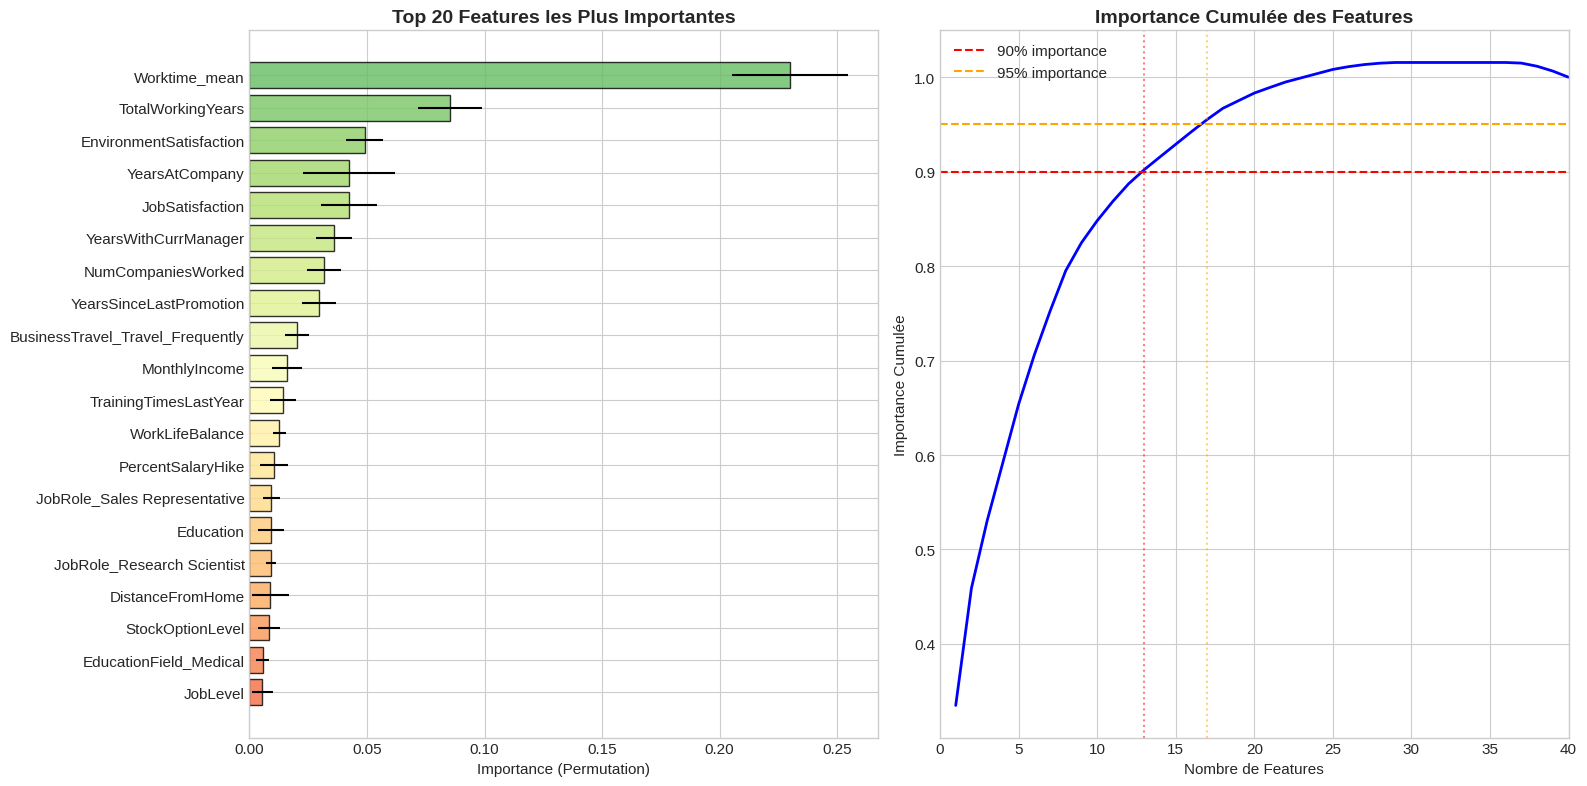


📈 13 features expliquent 90% de l'importance
📈 17 features expliquent 95% de l'importance


In [30]:
from sklearn.inspection import permutation_importance

print("🔄 Calcul de l'importance des features (permutation)...")

# Calcul de l'importance par permutation (fonctionne pour tous les modèles)
perm_importance = permutation_importance(
    best_model_final,  
    X_test_processed, 
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='f1'  # Ajout d'un scoring explicite
)

importances = perm_importance.importances_mean

# Vérification que nous avons des résultats
if len(importances) != len(all_feature_names):
    print(f"⚠️ Attention: {len(importances)} importances pour {len(all_feature_names)} features")
    # Ajuster si nécessaire
    if len(importances) < len(all_feature_names):
        all_feature_names = all_feature_names[:len(importances)]

# DataFrame des importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names[:len(importances)],
    'Importance': importances,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("📊 Top 15 Features les plus importantes:")
display(feature_importance_df.head(15))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_n = min(20, len(feature_importance_df))  # Prendre au max 20 features
top_features = feature_importance_df.head(top_n)

# Barplot horizontal avec barres d'erreur
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_features)))
axes[0].barh(
    range(len(top_features)), 
    top_features['Importance'].values, 
    xerr=top_features['Std'].values,
    color=colors,
    alpha=0.8,
    edgecolor='black'
)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance (Permutation)')
axes[0].set_title(f'Top {top_n} Features les Plus Importantes', fontsize=14, fontweight='bold')

# Importance cumulée
cumulative_importance = np.cumsum(feature_importance_df['Importance'].values / feature_importance_df['Importance'].sum())
axes[1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-', linewidth=2)
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% importance')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% importance')

n_90 = np.argmax(cumulative_importance >= 0.9) + 1 if any(cumulative_importance >= 0.9) else len(cumulative_importance)
n_95 = np.argmax(cumulative_importance >= 0.95) + 1 if any(cumulative_importance >= 0.95) else len(cumulative_importance)
axes[1].axvline(x=n_90, color='r', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_95, color='orange', linestyle=':', alpha=0.5)

axes[1].set_xlabel('Nombre de Features')
axes[1].set_ylabel('Importance Cumulée')
axes[1].set_title('Importance Cumulée des Features', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xlim([0, len(cumulative_importance)])

plt.tight_layout()
plt.show()

print(f"\n📈 {n_90} features expliquent 90% de l'importance")
print(f"📈 {n_95} features expliquent 95% de l'importance")

### 5.3 Analyse des Features Importantes par Département

Étudions comment les facteurs d'attrition varient selon le département.

📊 Taux d'attrition par département:
  • Human Resources: 30.2%
  • Research & Development: 15.7%
  • Sales: 15.0%


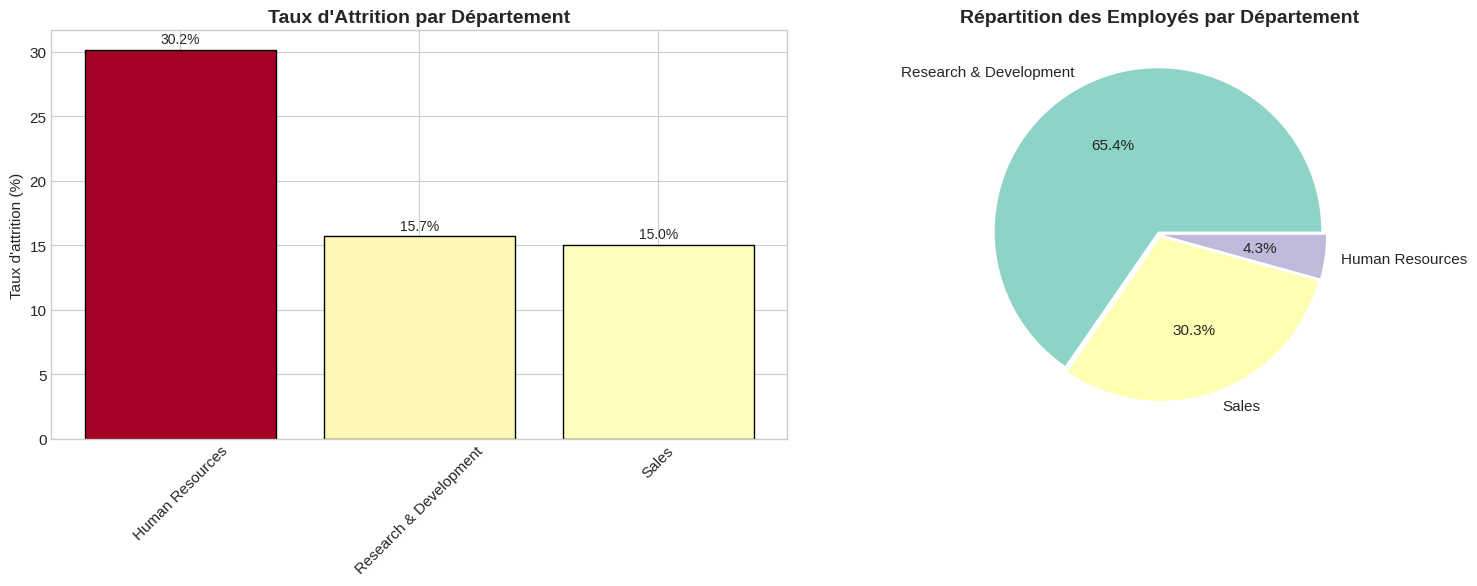

In [31]:
# Analyse par département
if 'Department' in df_clean.columns:
    departments = df_clean['Department'].unique()
    
    print("📊 Taux d'attrition par département:")
    dept_attrition = df_clean.groupby('Department')['Attrition'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).sort_values(ascending=False)
    
    for dept, rate in dept_attrition.items():
        print(f"  • {dept}: {rate:.1f}%")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Barplot taux d'attrition
    colors = plt.cm.RdYlGn_r(dept_attrition.values / dept_attrition.max())
    axes[0].bar(dept_attrition.index, dept_attrition.values, color=colors, edgecolor='black')
    axes[0].set_ylabel('Taux d\'attrition (%)')
    axes[0].set_title('Taux d\'Attrition par Département', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Ajout des valeurs
    for i, (idx, val) in enumerate(dept_attrition.items()):
        axes[0].text(i, val + 0.5, f'{val:.1f}%', ha='center', fontsize=10)
    
    # Nombre d'employés par département
    dept_counts = df_clean['Department'].value_counts()
    axes[1].pie(dept_counts.values, labels=dept_counts.index, autopct='%1.1f%%',
                colors=plt.cm.Set3.colors[:len(dept_counts)], explode=[0.02]*len(dept_counts))
    axes[1].set_title('Répartition des Employés par Département', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

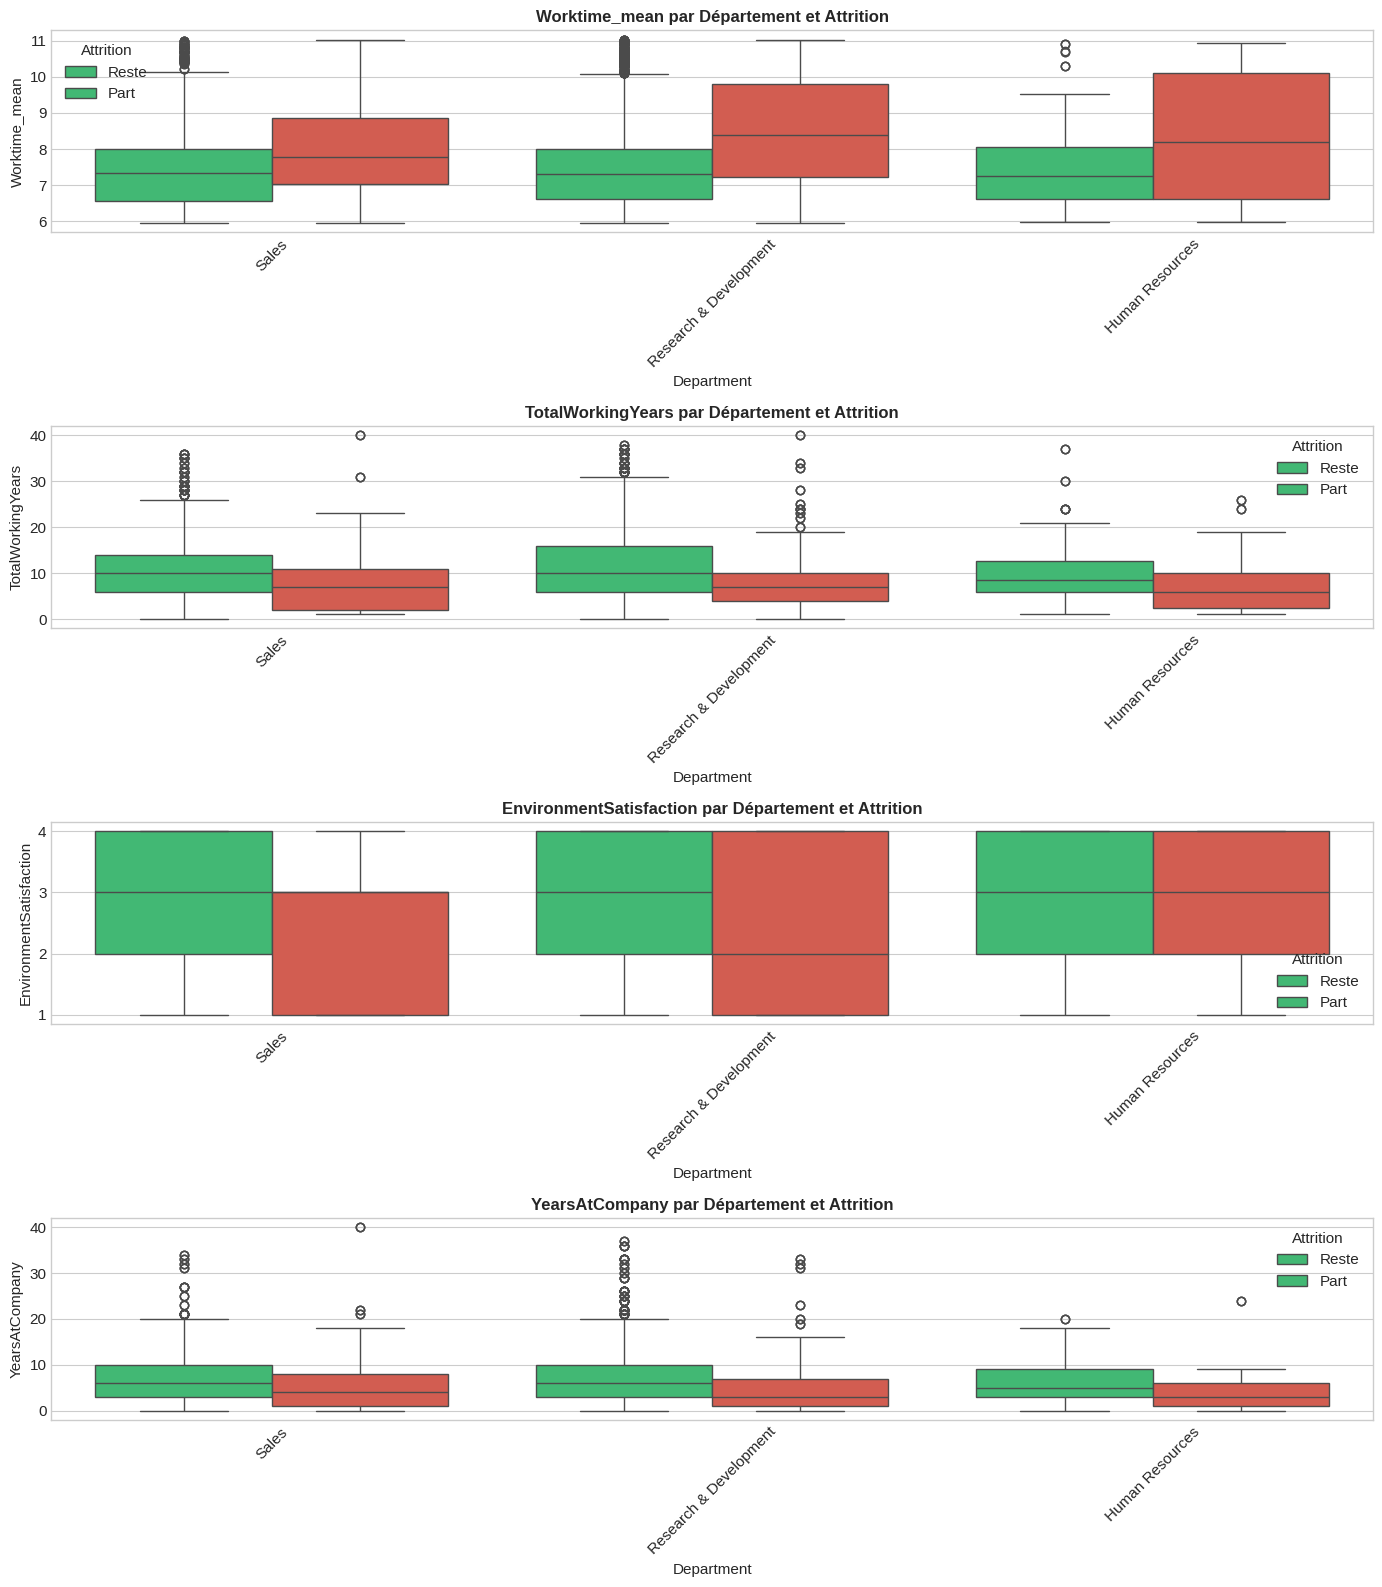

In [32]:
# Analyse des features numériques importantes par département et attrition
if 'importances' in locals() and importances is not None and 'Department' in df_clean.columns:
    # Top 4 features numériques importantes
    top_numeric_features = [
        f for f in feature_importance_df['Feature'].head(10).values 
        if f in numeric_features
    ][:4]
    
    if len(top_numeric_features) > 0:
        fig, axes = plt.subplots(len(top_numeric_features), 1, figsize=(14, 4 * len(top_numeric_features)))
        if len(top_numeric_features) == 1:
            axes = [axes]
        
        for idx, feature in enumerate(top_numeric_features):
            ax = axes[idx]
            
            # Boxplot par département et attrition
            data_plot = df_clean[[feature, 'Department', 'Attrition']].copy()
            
            sns.boxplot(data=data_plot, x='Department', y=feature, hue='Attrition',
                       palette=['#2ecc71', '#e74c3c'], ax=ax)
            ax.set_title(f'{feature} par Département et Attrition', fontsize=12, fontweight='bold')
            ax.tick_params(axis='x', rotation=45)
            ax.legend(title='Attrition', labels=['Reste', 'Part'])
        
        plt.tight_layout()
        plt.show()
    else:
        print("ℹ️ Aucune feature numérique dans le top 10 des features importantes")
else:
    print("ℹ️ Analyse par département non disponible (importances ou Department manquants)")

### 5.4 Résumé et Recommandations

In [33]:
print("=" * 70)
print("📋 RÉSUMÉ ET RECOMMANDATIONS")
print("=" * 70)

print(f"\n🏆 Meilleur modèle: {best_model_name}")
print(f"   F1 Score: {best_metrics['f1']:.4f}")
if 'f2' in best_metrics:
    print(f"   F2 Score: {best_metrics['f2']:.4f} (priorité recall)")
print(f"   Seuil optimal: {optimal_threshold:.3f}")
if best_metrics['roc_auc']:
    print(f"   ROC AUC: {best_metrics['roc_auc']:.4f}")

if importances is not None:
    print("\n📊 Top 5 facteurs d'attrition:")
    for i, row in feature_importance_df.head(5).iterrows():
        print(f"   {i+1}. {row['Feature']} (importance: {row['Importance']:.4f})")

print("\n💡 Recommandations pour réduire l'attrition:")
print("   • Surveiller les employés avec des scores bas sur les features importantes")
print("   • Mettre en place des programmes de rétention ciblés par département")
print("   • Utiliser ce modèle pour identifier proactivement les employés à risque")
print("   • Collecter des données supplémentaires sur les raisons de départ")

print("\n📁 Fichiers sauvegardés:")
print("   • attrition_model.joblib")
print("   • attrition_preprocessor.joblib")
print("   • attrition_metadata.joblib")



📋 RÉSUMÉ ET RECOMMANDATIONS

🏆 Meilleur modèle: Random Forest
   F1 Score: 0.9474
   F2 Score: 0.9393 (priorité recall)
   Seuil optimal: 0.540
   ROC AUC: 0.9932

📊 Top 5 facteurs d'attrition:
   19. Worktime_mean (importance: 0.2300)
   8. TotalWorkingYears (importance: 0.0853)
   13. EnvironmentSatisfaction (importance: 0.0490)
   10. YearsAtCompany (importance: 0.0424)
   14. JobSatisfaction (importance: 0.0423)

💡 Recommandations pour réduire l'attrition:
   • Surveiller les employés avec des scores bas sur les features importantes
   • Mettre en place des programmes de rétention ciblés par département
   • Utiliser ce modèle pour identifier proactivement les employés à risque
   • Collecter des données supplémentaires sur les raisons de départ

📁 Fichiers sauvegardés:
   • attrition_model.joblib
   • attrition_preprocessor.joblib
   • attrition_metadata.joblib
